# Tutorial: Supervised Learning Problem and Least Squares

Tutorial to the class [Supervised Learning Problem and Least Squares](2_supervised_learning_problem_ols.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Read, plot and analyze train data
- Use supervised learning to predict the regional electricity consumption of France in response electric heating based on temperature data
- Test the linear least squares (OLS) model
- Evaluate their performance by estimating their Expected Prediction Errors (EPE) using test data
</div>

## Dataset presentation

- Input:
  - 2m-temperature
    - Domain: Metropolitan France
    - Spatial resolution: regional average
    - Time resolution: hourly
    - Period: 2014-2019
    - Units: °C
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Electricity demand
    - Domain: Metropolitan France
    - Spatial resolution: regional sum
    - Time resolution: hourly
    - Period: 2014-2018
    - Units: MWh
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

## Reading and pre-analysis of the input and output data

### Import data-analysis and plot modules and define paths

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Plot module
import matplotlib.pyplot as plt

In [2]:
# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict()

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define temperature filepath
temp_filename = 'surface_temperature_merra2_{}-{}.csv'.format(
    FIRST_YEAR, LAST_YEAR)
temp_filepath = Path(data_dir, temp_filename)

# Define electricity demand filepath
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)

### Reading and plotting the raw temperature data

> ***Question (code cells below)***
> - Use `pd.read_csv` with the filepath and appropriate options to make sure to get the column names and the index as dates (`DatetimeIndex`).
> - Use the `resample` method from the data frame to compute daily means.
> - Plot the `'Île-de-France'` daily-mean temperature time series for (a) the whole period, (b) one year, (c) one month in winter and (d) one month in summer on 4 different figures (use `plt.figure`) using `plt.plot` or the `plot` method from data frames (preferably).
> - Use the `mean` and `var` methods to get mean and variance of the daily-mean temperature.

In [3]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer: Union[ForwardRef('PathLike[str]'), str, IO[~T], io.RawIOBase, io.BufferedIOBase, io.TextIOBase, _io.TextIOWrapper, mmap.mmap], sep=<object object at 0x7f6db484aa50>, delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: str = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, error_bad_lines=True, warn_bad_lines=True, delim_whit

Mean: Grand Est                     10.618527
Nouvelle-Aquitaine            12.864047
Auvergne-Rhône-Alpes          10.234978
Bourgogne-Franche-Comté       10.995382
Bretagne                      11.984747
Centre-Val de Loire           11.951470
Île-de-France                 11.293667
Occitanie                     12.580999
Hauts-de-France               10.731459
Normandie                     11.045734
Pays de la Loire              12.254374
Provence-Alpes-Côte d'Azur    12.128236
dtype: float64

Var: Grand Est                     51.904292
Nouvelle-Aquitaine            39.951391
Auvergne-Rhône-Alpes          51.123997
Bourgogne-Franche-Comté       50.578793
Bretagne                      22.048956
Centre-Val de Loire           44.914277
Île-de-France                 42.474751
Occitanie                     44.550002
Hauts-de-France               35.425500
Normandie                     30.995746
Pays de la Loire              33.354190
Provence-Alpes-Côte d'Azur    45.627665
dtype: float6

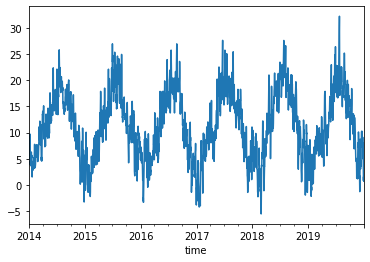

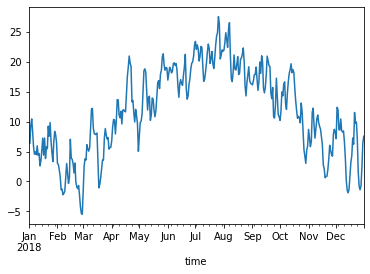

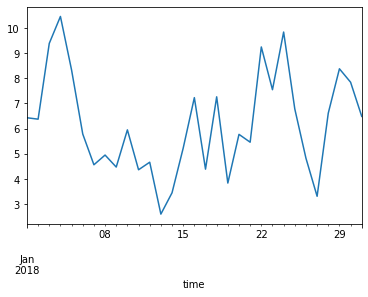

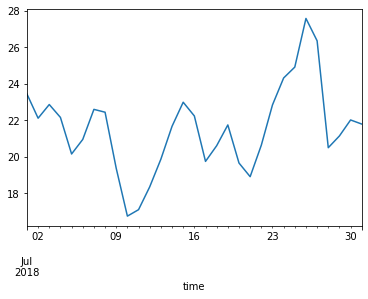

In [46]:
# Read hourly temperature data averaged over each region
df_temp_hourly = pd.read_csv(temp_filepath, index_col=0, parse_dates=True, header=0)

# Get daily-mean temperature
df_temp = df_temp_hourly.resample('D').mean()

# Select Île-de-France region
region_name = 'Île-de-France'
df_temp_idf = df_temp[region_name]

# Plot daily-mean temperature time series
plt.figure()
df_temp_idf.plot()

plt.figure()
df_temp_idf['2018'].plot()

plt.figure()
df_temp_idf['2018-01'].plot()

plt.figure()
df_temp_idf['2018-07'].plot()

# Compute mean and variance of daily temperature
print('Mean:', df_temp.mean())
print('\nVar:', df_temp.var())

### Reading and plotting the demand data

> ***Question***
> - Same question for the demand but with daily sums instead of daily means

Mean: Auvergne-Rhône-Alpes          364910.184009
Bourgogne-Franche-Comté       117406.004381
Bretagne                      121037.489047
Centre-Val de Loire           102865.324754
Grand Est                     251071.030668
Hauts-de-France               279758.711391
Île-de-France                 391160.240964
Normandie                     153403.902519
Nouvelle-Aquitaine            237675.443593
Occitanie                     204160.371851
Pays de la Loire              148249.504929
Provence-Alpes-Côte d'Azur    224558.384447
dtype: float64

Var: Auvergne-Rhône-Alpes          4.710731e+09
Bourgogne-Franche-Comté       5.849815e+08
Bretagne                      8.159934e+08
Centre-Val de Loire           5.987463e+08
Grand Est                     2.044595e+09
Hauts-de-France               2.397935e+09
Île-de-France                 7.800427e+09
Normandie                     1.003435e+09
Nouvelle-Aquitaine            2.465946e+09
Occitanie                     1.974904e+09
Pays de la Loir

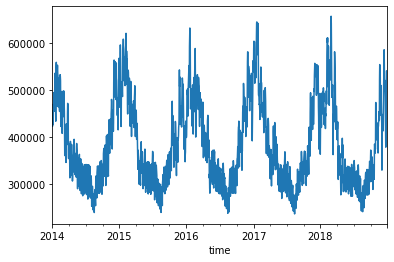

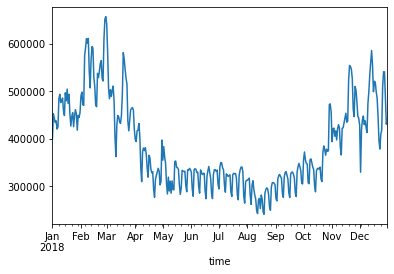

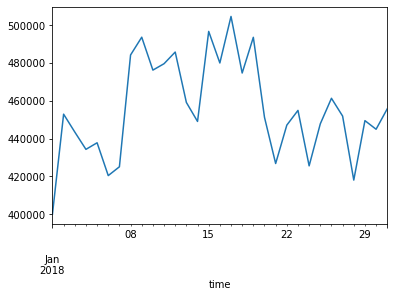

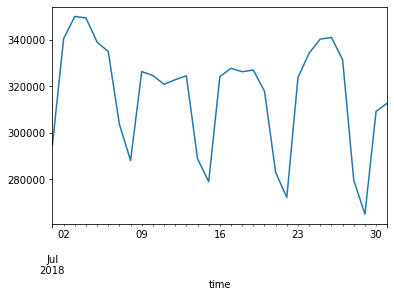

In [47]:
# Read hourly demand data averaged over each region
df_dem_hourly = pd.read_csv(dem_filepath, index_col=0, header=0, parse_dates=True)

# Get daily-summed demand
df_dem = df_dem_hourly.resample('D').sum()

# Select Île-de-France region
region_name = 'Île-de-France'
df_dem_idf = df_dem[region_name]

# Plot daily demand time series
plt.figure()
df_dem_idf.plot()

plt.figure()
df_dem_idf['2018'].plot()

plt.figure()
df_dem_idf['2018-01'].plot()

plt.figure()
df_dem_idf['2018-07'].plot()

# Compute mean and variance of daily demerature
print('Mean:', df_dem.mean())
print('\nVar:', df_dem.var())

### Analyzing the input and target data and their relationships

> ***Question (write answer in text box below)***
> - Describe the seasonality of the temperature in Île-de-France.
> - Are all years the same?
> - Describe the seasonal and weakly demand patterns.

Answer:

> ***Question***
> - Select the temperature and demand data for their largest common period using the `intersection` method of the `index` attribute of the data frames.
> - Represent a scatter plot of the daily demand versus the daily temperature using `plt.scatter`.

In [55]:
# Select the temperature and the demand data for their largest common period
# Solution 1
common_index = df_dem_idf.index.intersection(df_temp_idf.index)
df_dem_idf = df_dem_idf.loc[common_index]
df_temp_idf = df_temp_idf.loc[common_index]

# Solution 2
df = pd.merge(df_temp_idf, df_dem_idf, on='time')
df.columns = ['temp', 'demand']

# Scatter plot of demand versus temperature
df.plot(kind='scatter', x='temp', y='demand')

,temp,demand
time,,
2014-01-01 00:00:00+00:00,6.840232,423100
2014-01-02 00:00:00+00:00,8.002626,455859
2014-01-03 00:00:00+00:00,8.967253,450949
2014-01-04 00:00:00+00:00,7.203723,425710
2014-01-05 00:00:00+00:00,4.913896,431656
...,...,...
2018-12-27 00:00:00+00:00,-1.406258,540817
2018-12-28 00:00:00+00:00,-0.760199,540663
2018-12-29 00:00:00+00:00,2.318830,483363


> ***Question***
> - Compute the correlation between the daily temperature and the daily demand in Île-de-France using `np.corrcoef`.
> - Compute the correlation between the monthly temperature and the monthly demand using the `resample` method.

In [65]:
# Correlation between the daily temperature and demand
np.corrcoef(df_temp_idf, df_dem_idf)[0, 1]


# Correlation between the monthly temperature and demand
np.corrcoef(df_temp_idf.resample('M').mean(), df_dem_idf.resample('M').sum())

array([[ 1.        , -0.95379924],
       [-0.95379924,  1.        ]])

## Ordinary Least Squares

> ***Question***
> - Perform an OLS with intercept using the entire dataset from the temperature using the formula for the optimal coefficients derived in [Supervised Learning Problem and Least Squares](2_supervised_learning_problem_ols.ipynb) (without Scikit-Learn). To do so:
>   - Prepare the input matrix and output vector;
>   - Use the matrix-multiplication operator seen in [Introduction](1_introduction.ipynb) to compute the optimal coefficients and print them.
> - Use the estimated coefficents to predict the target from the input train data.
> - Overlay your prediction to the scatter plot of the train data.
> - Compute the train Mean Squared Error (MSE) and the train coefficient of determination ($R^2$) and print them.

In [ ]:
# Prepare the input matrix and output vector

# Compute the optimal coefficients

# Print the coefficients

# Predict from the train input data

# Plot the prediction on top of the scatter plot of the train data

# Compute the MSE and R2 and print them


> ***Question***
> - Compute the optimal coefficients using centered input temperatures.
> - Compute the optimal intercept alone using a single-column input matrix.
> - Compare the resulting two estimations of the intercept with the sample mean of the target train data.

In [ ]:
# Compute the optimal coefficients using centered input temperatures

# Compute the optimal intercept alone using a single-column input matrix

# Compare the resulting two estimations of the intercept with the sample mean of the target train data


> ***Question***
> - Perform an OLS fit with intercept using the entire dataset to predict the demand from the temperature using Scikit-learn. To do so:
>   - Import the `linear_model` module from `sklearn` (Scikit-Learn)
>   - Define a regressor using `linear_model.LinearRegression` (by default, the regressor is configured to fit an intercept in addition to the features, see `fit_intercept` option)
>   - Prepare the input matrix and output vector for the `fit` method of the regressor
>   - Apply the `fit` method to the input and output
> - Print the fitted coefficients using the `coef_` attribute of the regressor.
> - Compute the $R^2$ coefficient using the `score` method of the regressor.
> - Compare the resulting coefficients and score to those obtained above by applying the formulas yourself.

In [ ]:
# Import linear_model from sklearn
from sklearn import linear_model

# Define a linear regressor
reg = linear_model.LinearRegression()

# Prepare input and output for fit
X = df_temp_idf.values[:, None]

y = df_dem_idf.values

# Fit
reg.fit(X, y)

# Print
reg.intercept_, reg.coef_

# Compute the R2 coefficient with score

# Compare


Answer: 

> ***Question***
> - Define and array of 100 temperatures ranging from -5 to 35°C with `np.linspace`.
> - Make a prediction of the demand for these temperatures using the trained OLS model with the `predict` method of the regressor.
> - Plot this prediction over the scatter plot of the train data.
> - Does the demand prediction seem satisfactory over the whole range of temperatures?

In [ ]:
# Define an array of 100 temperatures ranging from -5 to 35°C
x_pred = 

# Prepare these temperatures for the prediction
X_pred = 

# Predict
y_pred = 

# Plot scatter plot of the train data

# Plot prediction


Answer:

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>